# Amazon Review Text Mining
### Jun Hee Kim

In this task, our goal is to predict the rating score (an integer out of 1, 2, 3, 4, 5) given only the Amazon review text. In other words, we will try to capture the customer's overall satisfaction about the product from the review text that he/she wrote. We will explore diverse types of preprocessing raw text data into a format that can be provided to machine learning models. More specifically, we will try several bag-of-words models to represent the Amazon review text and examine which type of representation of the text yields the best predictive performance.

For the data, we will be using the Amazon reviews on movies and TV ranging from May 1996 to July 2014. Here is the dataset source: http://jmcauley.ucsd.edu/data/amazon/. The original dataset contains information about 1697533 reviews.

## Import Libraries

First, we load the libraries that we will use for our work.

In [1]:
import numpy as np
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
import re
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

## Load Dataset

Let's load the dataset, which is originally in json format, as a Pandas dataframe. The original dataset contains the following variables:
- "reviewerID": ID of the reviewer, e.g. A2SUAM1J3GNN3B
- "asin": ID of the product, e.g. 0000013714
- "reviewerName": name of the reviewer
- "helpful": helpfulness rating of the review, e.g. 2/3
- "reviewText": text of the review
- "overall": rating of the product
- "summary": summary of the review
- "unixReviewTime": time of the review (unix time)
- "reviewTime": time of the review (raw)

Since our goal is to predict the rating score solely from the review text, we only keep these columns: "overall" is for the rating score (an integer out of 1, 2, 3, 4, 5) and "reviewText" is for the corresponding review text (string)

In [2]:
##### The following 5 lines of commented code is for loading the dataset from the original file and saving as a pickle file. #####
## Load data from original file
#reviews_df = pd.read_json('Movies_and_TV_5.json', \
#                             lines=True).drop(['reviewerID','asin','reviewerName','helpful','summary','unixReviewTime','reviewTime'], \
#                                              axis=1)
## Save this Pandas dataframe as a pickle file (so that we don't have to load it again later)
#reviews_df.to_pickle('reviews_df.pickle')

# Load the dataframe that has been already saved as a pickle file
reviews_df = pd.read_pickle('reviews_df.pickle')

As shown in the following cell, our dataframe has 1697533 datapoints each with 2 variables.

In [3]:
reviews_df.shape

(1697533, 2)

The first five rows of the dataframe looks like:

In [4]:
reviews_df.head()

,overall,reviewText
0,4,This is a charming version of the classic Dick...
1,3,It was good but not as emotionally moving as t...
2,3,"Don't get me wrong, Winkler is a wonderful cha..."
3,5,Henry Winkler is very good in this twist on th...
4,4,This is one of the best Scrooge movies out. H...


## Data Preprocessing

In this section, we perform preprocessing on the 'reviewText' feature. Our first step of preprocessing the text is tokenization. After tokenizing, we remove all tokens that include numbers, remove all punctuations across the tokens, and convert the tokens to lowercase.

In [38]:
def remove_tokens_with_num(tokens):
    """
    'tokens' is a list of tokens.
    Returns a list of tokens where only tokens without numbers are maintained
    """
    return [token for token in tokens if not re.search('\d', token)]
remove_tokens_with_num(['where', 'is', '3es', 'air', 'd2oy'])

['where', 'is', 'air']

In [39]:
def remove_punc_in_str(str_):
        """
        'str' is a string.
        Returns the string where the punctuations (if any) are removed
        """
        for punctuation in string.punctuation:
            str_ = str_.replace(punctuation, "")
        return str_
remove_punc_in_str('I ** am a person! How are you? hey^^')

'I  am a person How are you hey'

In [40]:
def tokens_to_lowercase(tokens):
    """
    'tokens' is a list of tokens.
    Returns a list of tokens where all the alphabets are converted to lowercase.
    """
    return [token.lower() for token in tokens]
tokens_to_lowercase(['Where', 'i?s', '3eS!', 'a*ir', 'd2oy'])

['where', 'i?s', '3es!', 'a*ir', 'd2oy']

In [41]:
def remove_stopwords(tokens, stopwords):
    """
    'tokens' is a list of tokens. 'stopwords' is a set of stopwords (Use a set, not a list, for stopwords to make search faster)
    Returns a list of tokens in which all the tokens that are stopwords
    """
    return [token for token in tokens if token not in stopwords]

remove_stopwords(['Where', 'i?s', '3eS!', 'a*ir', 'at', 'd2oy'], {"at", "any"})

['Where', 'i?s', '3eS!', 'a*ir', 'd2oy']

Using the functions that we made, we preprocess the 'reviewText' feature in our dataframe. For the stop words, we use the stopwords provided by the nltk library.

In [45]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [10]:
reviews_df['reviewText_processed'] = [remove_stopwords(tokens_to_lowercase(remove_tokens_with_num(nltk.word_tokenize(remove_punc_in_str(review)))), \
                                                          stopwords=stop_words) \
                                         for review in reviews_df['reviewText']]

The first five rows' preprocessed review text looks like:

In [11]:
reviews_df['reviewText_processed'][0:5]

0    [charming, version, classic, dickens, tale, he...
1    [good, emotionally, moving, christmas, carol, ...
2    [dont, get, wrong, winkler, wonderful, charact...
3    [henry, winkler, good, twist, classic, story, ...
4    [one, best, scrooge, movies, henry, winkler, o...
Name: reviewText_processed, dtype: object

Since we are not going to use the original review text anymore, let's delete it from our dataframe.

In [12]:
reviews_df.drop(['reviewText'], axis=1, inplace=True)

Now our dataframe's first five rows look like:

In [13]:
## Save this Pandas dataframe as a pickle file (so that we don't have to load it again later)
#reviews_df.to_pickle('preprocessed_reviews_df.pickle')

# Load the dataframe that has been already saved as a pickle file
reviews_df = pd.read_pickle('preprocessed_reviews_df.pickle')
reviews_df.head()

,overall,reviewText_processed
0,4,"[charming, version, classic, dickens, tale, he..."
1,3,"[good, emotionally, moving, christmas, carol, ..."
2,3,"[dont, get, wrong, winkler, wonderful, charact..."
3,5,"[henry, winkler, good, twist, classic, story, ..."
4,4,"[one, best, scrooge, movies, henry, winkler, o..."


## Data Splitting

Now, let's split the dataset as the training set, validation set, and the test set. We will use 1018519 datapoints for the training set (around 60% of the entire 1697533), 339506 for the validation set (around 20% of the entire 1697533), and the test set will consist of the remaining 339508 datapoints.

- All the fitting will be done via the training set.
- Hyperparameter tuning and model selection (performance evaluation) will be done via the validation set. (Note: We could instead do k-fold cross validation, but since we have reasonably many datapoints in the validation set and also to reduce computational time, we use the train-validation-test approach)
- The final model's accuracy will be evaluated via the test set.

In [14]:
n = reviews_df.shape[0]
num_train = 1018519
num_valid = 339506
np.random.seed(0)
indices_permutation = np.random.permutation(n)
train_ind = indices_permutation[0:num_train]
valid_ind = indices_permutation[num_train:num_train+num_valid]
test_ind = indices_permutation[num_train+num_valid:]
train_df = reviews_df.iloc[train_ind]
valid_df = reviews_df.iloc[valid_ind]
test_df = reviews_df.iloc[test_ind]

In [2]:
# Save these dataframes for future use
#train_df.to_pickle('train_df.pickle')
#valid_df.to_pickle('valid_df.pickle')
#test_df.to_pickle('test_df.pickle')

# load the already-saved dataframes
train_df = pd.read_pickle('train_df.pickle')
valid_df = pd.read_pickle('valid_df.pickle')
test_df = pd.read_pickle('test_df.pickle')

The number of rows and the number of columns for the three datasets are:

In [3]:
train_df.shape, valid_df.shape, test_df.shape

((1018519, 2), (339506, 2), (339508, 2))

## Training Data - Rating Distribution

Let's observe the frequency distribution of the rating scores in our dataset.

In [4]:
rating_freq_dict = Counter(train_df['overall'])
print("Ratings Frequency Distribution: ", rating_freq_dict)
# and the coresponding percentage
num_train_instances = train_df.shape[0]
for rate in [1,2,3,4,5]:
   print("Percentage of training instances with %d-star rating:" %rate, (rating_freq_dict[rate]/num_train_instances)*100, "%")

Ratings Frequency Distribution:  Counter({5: 543793, 4: 229244, 3: 120992, 1: 62876, 2: 61614})
Percentage of training instances with 1-star rating: 6.173277081723561 %
Percentage of training instances with 2-star rating: 6.0493716857515665 %
Percentage of training instances with 3-star rating: 11.879208929828506 %
Percentage of training instances with 4-star rating: 22.50758208732483 %
Percentage of training instances with 5-star rating: 53.39056021537153 %


([<matplotlib.axis.XTick at 0x209b6755b70>,
 <a list of 5 Text xticklabel objects>)

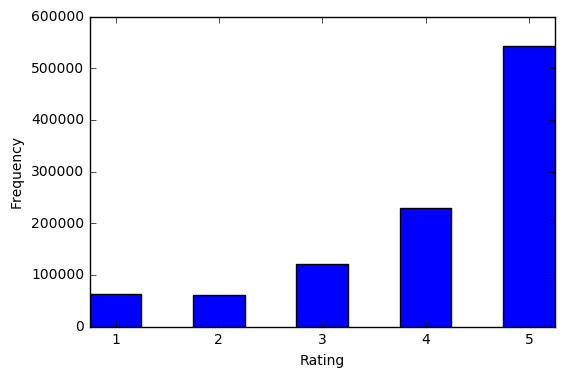

In [5]:
plt.bar([1,2,3,4,5], [rating_freq_dict[rate] for rate in [1,2,3,4,5]], width=0.5)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks([1.25,2.25,3.25,4.25,5.25], [1,2,3,4,5])

Since the ratings 4 and 5 are much more frequent compared to the other ratings, let's downsample those labels. Let's (randomly) maintain just the 30% of the 5-star ratings (maintain 163137 observations and remove 380656 observations), and also let's (randomly) maintain just the 60% of the 4-star ratings (maintain 137546 observations and remove 91698 observations).

In [6]:
# 5-star ratings
rating5_rows = train_df.index[train_df['overall']==5].tolist()
np.random.seed(0)
rating5_rows_perm = np.random.permutation(rating5_rows)
rows_to_delete = rating5_rows_perm[0:380656]
train_df.drop(rows_to_delete, inplace=True)
# 4-star ratings
rating4_rows = train_df.index[train_df['overall']==4].tolist()
np.random.seed(0)
rating4_rows_perm = np.random.permutation(rating4_rows)
rows_to_delete = rating4_rows_perm[0:91698]
train_df.drop(rows_to_delete, inplace=True)

In [7]:
# Save the dataframe for future use
#train_df.to_pickle('train_balanced_df.pickle')

# Load the already-saved dataframe
train_df = pd.read_pickle('train_balanced_df.pickle')

Now, the distribution of the ratings in the training set looks more balanced compared to the original training set (as shown below).

([<matplotlib.axis.XTick at 0x20931af5710>,
 <a list of 5 Text xticklabel objects>)

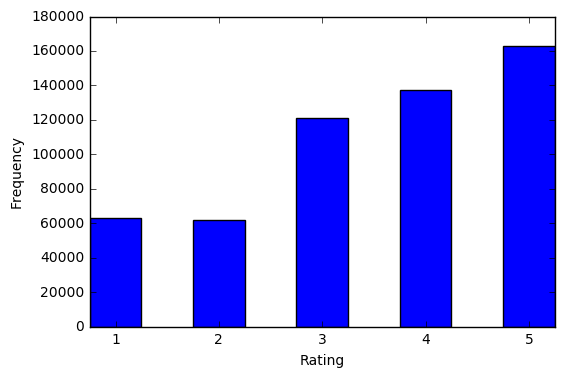

In [8]:
rating_freq_dict = Counter(train_df['overall'])
plt.bar([1,2,3,4,5], [rating_freq_dict[rate] for rate in [1,2,3,4,5]], width=0.5)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks([1.25,2.25,3.25,4.25,5.25], [1,2,3,4,5])

The number of rows and the number of columns for the training set are now:

In [9]:
train_df.shape

(546165, 2)

## Feature Design

In this section, we will try several feature designs of the training dataset. In particular, we will focus on bag-of-words (BOW) representations, in which we represent the training set as a matrix where each row corresponds to each training instance, and each column represents each token, or vocabulary. Different versions of the BOW feature design depends on the different ways to select the tokens to include (as columns). Then, each row $i$ & column $j$ entry of the feature matrix is the number of times the token in column $j$ appears in the review text in row $i$. Moreover, since most of the entries of the feature matrix will be 0, to deal with memory error issues, we use scipy sparse matrices.

### Feature Design 1: Top 3000 Collection Term Frequency

Again, what makes the feature design different is based on how we choose the tokens to include in our feature matrix. In this "top 3000 collection term frequency" design, we choose the top 3000 tokens, where the ranking is based on how many times the token appeared throughout the whole training set (that is: across all the 546165 review texts).

In [46]:
token_freq_dict = Counter([token for list_tokens in train_df['reviewText_processed'] for token in list_tokens])

# list of top 3000 tokens based on collection term frequency
top3000_CTF_tokens = [token_and_count[0] for token_and_count in token_freq_dict.most_common(3000)]
# first ten
top3000_CTF_tokens[0:10]

['movie',
 'film',
 'one',
 'like',
 'good',
 'great',
 'would',
 'story',
 'really',
 'time']

In [12]:
# Top 3000 CTF - Feature matrix
#X_sparse_top3000_CTF = sparse.vstack([sparse.csr_matrix([np.sum(np.array(list_tokens)==token) for token in top3000_CTF_tokens]) \
#                                      for list_tokens in train_df['reviewText_processed']])

# Save X_sparse_top3000_CTF as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_top3000_CTF.npz', X_sparse_top3000_CTF)

# Load it
X_sparse_top3000_CTF = sparse.load_npz('X_sparse_top3000_CTF.npz')

### Feature Design 2: Top 3000 Document Frequency

This time, we choose the top 3000 tokens, where the ranking is based on the number of training instances such that the token appears at least once in the training instance's review text.

In [47]:
unique_tokens = np.array(list(token_freq_dict.keys()))
each_token_df_dict = {unique_token:0 for unique_token in unique_tokens}

for list_tokens in train_df['reviewText_processed']:
    for token in np.unique(list_tokens):
        each_token_df_dict[token] += 1

top3000_DF_tokens = sorted(each_token_df_dict, key=each_token_df_dict.get)[::-1][0:3000]
# first ten
top3000_DF_tokens[0:10]

['movie',
 'one',
 'like',
 'good',
 'film',
 'great',
 'would',
 'time',
 'story',
 'really']

In [14]:
#X_sparse_top3000_DF = sparse.vstack([sparse.csr_matrix([np.sum(np.array(list_tokens)==token) for token in top3000_DF_tokens]) \
#                                      for list_tokens in train_df['reviewText_processed']])

# Save X_sparse_top3000_CTF as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_top3000_DF.npz', X_sparse_top3000_DF)

# Load it
X_sparse_top3000_DF = sparse.load_npz('X_sparse_top3000_DF.npz')

### Feature Design 3: TF-IDF

Our last feature design is the tf-idf (term frequency–inverse document frequency) which combines term frequency (a local statistic that shows how many times a term appears in a document) and inverse document frequency (a global statistic that is inversely proportional to the number of times a term appears across the entire collection of documents). Some more information about the tf-idf weighing scheme can be found [here](http://www.tfidf.com/).

In [15]:
def return_itself(text):
    return text

# Since we already did the tokenization, for the tokenizer and the preprocessor
# in our tfidf obejct, we use a function that simply returns the input text.
tfidf_vectorize = TfidfVectorizer(analyzer='word', tokenizer=return_itself, preprocessor=return_itself, token_pattern=None)

# Learn the vocabulary and idf values from the training dataset.
tfidf_vectorize.fit(train_df['reviewText_processed'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function return_itself at 0x00000208BBBB9EA0>,
        smooth_idf=True, stop_words=None, strip_accents=None,
        sublinear_tf=False, token_pattern=None,
        tokenizer=<function return_itself at 0x00000208BBBB9EA0>,
        use_idf=True, vocabulary=None)

In [16]:
# Based on the learned vocabulary and idf values, compute the tf-idf feature matrix for the training set.
#X_sparse_tfidf = tfidf_vectorize.transform(train_df['reviewText_processed'])

# Save X_sparse_tfidf as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_tfidf.npz', X_sparse_tfidf)

# Load it
X_sparse_tfidf = sparse.load_npz('X_sparse_tfidf.npz')

### Feature Designs on Validation Set and Test Set

For each of the five feature designs, let's create the corresponding feature matrix for the validation set.

In [17]:
# Validation set - Feature design 1: Top 3000 CTF
#X_sparse_valid_top3000_CTF = sparse.vstack([sparse.csr_matrix([np.sum(np.array(list_tokens)==token) for token in top3000_CTF_tokens]) \
#                                            for list_tokens in valid_df['reviewText_processed']])

# Save X_sparse_valid_top3000_CTF as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_valid_top3000_CTF.npz', X_sparse_valid_top3000_CTF)

# Load it
X_sparse_valid_top3000_CTF = sparse.load_npz('X_sparse_valid_top3000_CTF.npz')

In [18]:
# Validation set - Feature design 2: Top 3000 DF
#X_sparse_valid_top3000_DF = sparse.vstack([sparse.csr_matrix([np.sum(np.array(list_tokens)==token) for token in top3000_DF_tokens]) \
#                                           for list_tokens in valid_df['reviewText_processed']])

# Save X_sparse_valid_top3000_DF as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_valid_top3000_DF.npz', X_sparse_valid_top3000_DF)

# Load it
X_sparse_valid_top3000_DF = sparse.load_npz('X_sparse_valid_top3000_DF.npz')

In [19]:
# Validation set - Feature design 3: tf-idf
#X_sparse_valid_tfidf = tfidf_vectorize.transform(valid_df['reviewText_processed'])

# Save X_sparse_valid_tfidf as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_valid_tfidf.npz', X_sparse_valid_tfidf)

# Load it
X_sparse_valid_tfidf = sparse.load_npz('X_sparse_valid_tfidf.npz')

Repeat on the test set.

In [20]:
# Test set - Feature design 1: Top 3000 CTF
#X_sparse_test_top3000_CTF = sparse.vstack([sparse.csr_matrix([np.sum(np.array(list_tokens)==token) for token in top3000_CTF_tokens]) \
#                                           for list_tokens in test_df['reviewText_processed']])

# Save X_sparse_test_top3000_CTF as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_test_top3000_CTF.npz', X_sparse_test_top3000_CTF)

# Load it
X_sparse_test_top3000_CTF = sparse.load_npz('X_sparse_test_top3000_CTF.npz')

In [21]:
# Test set - Feature design 2: Top 3000 DF
#X_sparse_test_top3000_DF = sparse.vstack([sparse.csr_matrix([np.sum(np.array(list_tokens)==token) for token in top3000_DF_tokens]) \
#                                          for list_tokens in test_df['reviewText_processed']])

# Save X_sparse_test_top3000_DF as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_test_top3000_DF.npz', X_sparse_test_top3000_DF)

# Load it
X_sparse_test_top3000_DF = sparse.load_npz('X_sparse_test_top3000_DF.npz')

In [22]:
# Test set - Feature design 3: tf-idf
#X_sparse_test_tfidf = tfidf_vectorize.transform(test_df['reviewText_processed'])

# Save X_sparse_test_tfidf as a file, so we can load it again later instead of doing preprocessing again
#sparse.save_npz('X_sparse_test_tfidf.npz', X_sparse_test_tfidf)

# Load it
X_sparse_test_tfidf = sparse.load_npz('X_sparse_test_tfidf.npz')

## Model Selection

Now that we have the feature matrices, we begin training the model on the data.

We use the following models:
- Multinomial Naive Bayes
- Logistic Regression
- Linear Support Vector Machine (SVM)

We will decide the best model (out of total 9 models: combinations across three designs and three model types) based on the validation set, and then evaluate the final test accuracy (via the test dataset).

For our error metric in model selection, we use the root mean squared error (RMSE), which is defined as:

$\sqrt{\frac{1}{n} \sum_{i=1}^{n} (true_{i} - pred_{i})^{2}}$ 

where:
- $n$ denotes the number of datapoints (i.e. number of predictions)
- $true_{i}$ denotes the true label of the $i^{th}$ datapoint; for $i \in \{ 1, \cdots, n \}$
- $pred_{i}$ denotes the predicted label of the $i^{th}$ datapoint; for $i \in \{ 1, \cdots, n \}$

Of course, we could instead use other common metrics such as prediction accuracy, mean absolute error (MAE), etc. But we choose RMSE because:

- This task's labels are essentially numerical, so e.g. predicting a true label 3 as 2 is not as bad as predicting a true label 5 as 2. So accuracy might not be a good metric.
- With the similiar reason, since we want to penalize larger errors (i.e. difference between the true rating score and the predicted rating score) more, RMSE could be better than MAE.

In [23]:
# Function that computes the RMSE, given the true labels and the predicted labels
def rmse(trueY, predictedY):
    return math.sqrt(mean_squared_error(trueY, predictedY))

### Model 1: Multinomial Naive Bayes

First we consider a Multinomial Naive Bayes classifier, where we assume:

- Each feature (here, each token) is conditionally independent given the label (just like any Naive Bayes)
- Each feature has a Multinomial distribution, where the event probabilities are defined for each label. That is: For each label $c$, there is a set of probabilities that sum to 1 ($p_{1}^{(c)}, p_{2}^{(c)}, \cdots, p_{m}^{(c)}$ where $m$ denotes the number of features). This is why we call it the "Multinomial" Naive Bayes.

We need to choose the value of 'alpha', which is a hyperparameter representing the strength of the additive smoothing, which is a method of reducing the influence of rare words throughout the documents. The options are from 0 to 1 (So 'alpha'=0 means no smothing at all), and we decide the best value via the performance on the validation data.

#### Feature Design 1: Top 3000 Collection Term Frequency

In [24]:
alphas = [0.2, 0.5, 0.8, 1]

for alpha in alphas:
    # train the model with this alpha
    nb_clf1 = MultinomialNB(alpha=alpha).fit(X_sparse_top3000_CTF, train_df['overall'])
    # predict on validation set
    preds = nb_clf1.predict(X_sparse_valid_top3000_CTF)
    # compute RMSE
    print("alpha=", alpha, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

alpha= 0.2  RMSE= 1.2180286572283823
alpha= 0.5  RMSE= 1.2180431664362785
alpha= 0.8  RMSE= 1.217962154480632
alpha= 1  RMSE= 1.2178944388610145


#### Feature Design 2: Top 3000 Document Frequency

In [25]:
for alpha in alphas:
    # train the model with this alpha
    nb_clf2 = MultinomialNB(alpha=alpha).fit(X_sparse_top3000_DF, train_df['overall'])
    # predict on validation set
    preds = nb_clf2.predict(X_sparse_valid_top3000_DF)
    # compute RMSE
    print("alpha=", alpha, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

alpha= 0.2  RMSE= 1.2045914783114997
alpha= 0.5  RMSE= 1.2045230110222744
alpha= 0.8  RMSE= 1.2045609130382573
alpha= 1  RMSE= 1.204483885109605


#### Feature Design 3: TF-IDF

In [26]:
for alpha in alphas:
    # train the model with this alpha
    nb_clf3 = MultinomialNB(alpha=alpha).fit(X_sparse_tfidf, train_df['overall'])
    # predict on validation set
    preds = nb_clf3.predict(X_sparse_valid_tfidf)
    # compute RMSE
    print("alpha=", alpha, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

alpha= 0.2  RMSE= 1.0452000468671305
alpha= 0.5  RMSE= 1.0803356774590935
alpha= 0.8  RMSE= 1.1032842877898215
alpha= 1  RMSE= 1.1139807142665923


### Model 2: Logistic Regression (L2-regularized)

Next, we consider the logistic regression model. Note that we're dealing with classification with more than two labels, so binary logistic regression cannot be directly used. There are several ways to deal with multiclass classification via logistic regression, and we use the 'one vs rest' (aka 'one vs all') approach. 

Recall the binary logistic regression model: There are two possible labels $0$ and $1$, and the model says that the probability that a datapoint with features $x = [x_{1}, x_{2}, \cdots, x_{m}]$ has label $1$ is: $P(Y=1 | X=x) = \frac{\text{exp} \{ \beta_{0} + \beta_{1} x_{1} + \cdots + \beta_{m} x_{m} \}}{1 + \text{exp} \{ \beta_{0} + \beta_{1} x_{1} + \cdots + \beta_{m} x_{m} \} }$, and the probability that it has label $0$ is:  $P(Y=0 | X=x) = 1 - P(Y=1 | X=x)$.

Let $q$ denote the number of possible labels (so $q>2$). In the 'one vs rest' approach, we build one binary logistic regression model for each of the $q$ labels. For each $j \in \{1, \cdots, q\}$, the $j^{th}$ binary logistic regression model treats the label value $j$ as 'success' (i.e. Y=1), and all the other labels (i.e. all values in $\{ 1, \cdots, j-1, j+1, \cdots, q$) as 'failure' (i.e. Y=0). We train each of the $q$-many binary logistic regression models (so total $q$-many sets of parameters are fitted). Then, when making prediction for an arbitrary datapoint, we do:

- For each $j \in \{ 1, \cdots, q \}$, we compute the fitted probability of that datapoint having label $j$ via the $j^{th}$ binary logistic regression formula.
- Then, our prediction is the label $j$ that has the highest fitted probability.

Moreover, to prevent overfitting, we will apply L2-regularization. There is a hyperparameter 'C' which is the inverse of the strength of regularization (so smaller value means stronger regularization). As before, we will assess validation performance to choose our 'C'.

#### Feature Design 1: Top 3000 Collection Term Frequency

In [27]:
Cs = [0.25, 0.5, 1.0, 1.25]

for C in Cs:
    # train the model with this C
    lr_clf1 = LogisticRegression(penalty='l2', C=C).fit(X_sparse_top3000_CTF, train_df['overall'])
    # predict on validation set
    preds = lr_clf1.predict(X_sparse_valid_top3000_CTF)
    # compute RMSE
    print("C=", C, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

C= 0.25  RMSE= 1.0305175904727957
C= 0.5  RMSE= 1.0305604630273788
C= 1.0  RMSE= 1.0307233624713912
C= 1.25  RMSE= 1.030763368923047


#### Feature Design 2: Top 3000 Document Frequency

In [28]:
for C in Cs:
    # train the model with this C
    lr_clf2 = LogisticRegression(penalty='l2', C=C).fit(X_sparse_top3000_DF, train_df['overall'])
    # predict on validation set
    preds = lr_clf2.predict(X_sparse_valid_top3000_DF)
    # compute RMSE
    print("C=", C, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

C= 0.25  RMSE= 1.0229857841542933
C= 0.5  RMSE= 1.0232276145595993
C= 1.0  RMSE= 1.0233269212057456
C= 1.25  RMSE= 1.0233226037258707


#### Feature Design 3: TF-IDF

In [29]:
for C in Cs:
    # train the model with this C
    lr_clf3 = LogisticRegression(penalty='l2', C=C).fit(X_sparse_tfidf, train_df['overall'])
    # predict on validation set
    preds = lr_clf3.predict(X_sparse_valid_tfidf)
    # compute RMSE
    print("C=", C, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

C= 0.25  RMSE= 0.9508953610117883
C= 0.5  RMSE= 0.9478626593688789
C= 1.0  RMSE= 0.9490117272716462
C= 1.25  RMSE= 0.9501423556267181


### Model 3: Linear SVM (L2-regularized)

Lastly, we consider the linear SVM model. Note that we can use nonlinear SVM via kernels, but we won't do so here. Again, we're dealing with a multiclass classification task, so binary SVM can't be directly used. As in logistic regression, we use the 'one vs rest' approach, where each label has its own binary linear SVM classifier that treats itself as one class and all other labels as the other class.

Recall the binary linear SVM model: It has two labels, and its goal is to learn the hyperplane (dimension depends on number of features) that has the maximum margin. This is done by minimizing the hinge loss. Here, we have a hyperparameter 'C' which represents the penalty to the error terms (i.e. how severely will we penalize misclassification of training data). So smaller value of this hyperparameter can prevent overfitting.

#### Feature Design 1: Top 3000 Collection Term Frequency

In [30]:
Cs = [0.25, 0.5, 1, 1.25]

for C in Cs:
    # train the model with this C
    svm_clf1 = LinearSVC(penalty='l2', loss='hinge', C=C).fit(X_sparse_top3000_CTF, train_df['overall'])
    # predict on validation set
    preds = svm_clf1.predict(X_sparse_valid_top3000_CTF)
    # compute RMSE
    print("C=", C, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

C= 0.25  RMSE= 1.1884688051807504
C= 0.5  RMSE= 1.150737811363019
C= 1  RMSE= 1.1772483387164265
C= 1.25  RMSE= 1.1300935581472134


#### Feature Design 2: Top 3000 Document Frequency

In [31]:
for C in Cs:
    # train the model with this C
    svm_clf2 = LinearSVC(penalty='l2', loss='hinge', C=C).fit(X_sparse_top3000_DF, train_df['overall'])
    # predict on validation set
    preds = svm_clf2.predict(X_sparse_valid_top3000_DF)
    # compute RMSE
    print("C=", C, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

C= 0.25  RMSE= 1.1503960508175202
C= 0.5  RMSE= 1.1438922123228141
C= 1  RMSE= 1.1594167627728131
C= 1.25  RMSE= 1.1418136331346997


#### Feature Design 3: TF-IDF

In [32]:
for C in Cs:
    # train the model with this C
    svm_clf3 = LinearSVC(penalty='l2', loss='hinge', C=C).fit(X_sparse_tfidf, train_df['overall'])
    # predict on validation set
    preds = svm_clf3.predict(X_sparse_valid_tfidf)
    # compute RMSE
    print("C=", C, " RMSE=", rmse(trueY=valid_df['overall'], predictedY=preds))

C= 0.25  RMSE= 1.0267851286246052
C= 0.5  RMSE= 1.0203261969482234
C= 1  RMSE= 1.0161621820484101
C= 1.25  RMSE= 1.0162549332781925


Here are the results.

For feature design 1 (Top 3000 Collection Term Frequency):
- The Naive Bayes model's best 'alpha' is 1 (with RMSE 1.218)
- The logistic regression model's best 'C' is 0.25 (with RMSE 1.031)
- The SVM model's best 'C' is 1.25 (with RMSE 1.13)

For feature design 2 (Top 3000 Document Frequency):
- The Naive Bayes model's best 'alpha' is 1 (with RMSE 1.204)
- The logistic regression model's best 'C' is 0.25 (with RMSE 1.023)
- The SVM model's best 'C' is 1.25 (with RMSE 1.142)

For feature design 3 (TF-IDF):
- The Naive Bayes model's best 'alpha' is 0.2 (with RMSE 1.045)
- The logistic regression model's best 'C' is 0.5 (with RMSE 0.948)
- The SVM model's best 'C' is 1.25 (with RMSE 1.016)

Overall, we can see that the TF-IDF feature design yields lower RMSE (which is better) compared to the other feature designs, and in regards to models, it seems the logistic regression model tends to yield lower RMSE compared to others. We choose the logistic regression model with 'C' = 0.5 with the TF-IDF feature design as our final model.

But note that we do not know about the uncertainty of those RMSE values, and we can use the bootstrap to estimate the uncertainty, which will let us determine whether those differences in RMSE values are meaningful (that is: not negligably small).

## Final Model Test Set Performance

Now we will fit the logistic regression model with 'C' = 0.5 with the TF-IDF design. Note that here, we will use both the training set and the validation set (combined into one dataset) to train the final model, and then assess the performance on test dataset prediction.

Also, for the performance metric, we will use MAE which gives us the exact 'distance' of the error.

In [33]:
# Combine training set and validation set
X_sparse_combined_tfidf = sparse.vstack((X_sparse_tfidf, X_sparse_valid_tfidf))

# Corresponding labels
true_labels_combined = train_df['overall'].append(valid_df['overall'])

In [34]:
# train the model with this C=0.5
lr_clf_final = LogisticRegression(penalty='l2', C=0.5).fit(X_sparse_combined_tfidf, true_labels_combined)
# predict on test set
preds = lr_clf_final.predict(X_sparse_test_tfidf)
# compute MAE
print("MAE=", mean_absolute_error(test_df['overall'], preds))

MAE= 0.502718639914


Our final model yields MAE of 0.503, which means that on average, the difference between the true rating and the predicted rating is near 0.5. Considering the fact that the ratings are integers from 1 to 5, this final test MAE is pretty good.

Lastly, let's examine two extreme examples (one very positive review and one very negative review) on how our final predicts the rating.

In [43]:
# positive
sentence1 = "This is very good. I love it, and I will watch it again."
# negative
sentence2 = "Horrible film. You won't like it. It is extremely bad."

extremes = pd.DataFrame({'reviewText':[sentence1, sentence2]})
extremes['reviewText_processed'] = [remove_stopwords(tokens_to_lowercase(remove_tokens_with_num(nltk.word_tokenize(remove_punc_in_str(review)))), \
                                                          stopwords=stop_words) \
                                         for review in extremes['reviewText']]
extremes.drop(['reviewText'], axis=1, inplace=True)

tfidf_extremes = tfidf_vectorize.transform(extremes['reviewText_processed'])

# predict
lr_clf_final.predict(tfidf_extremes)

array([5, 1], dtype=int64)

Our final model predicts the positive sentence as rating 5 and the negative sentence as rating 1, as desired.